# Machine Learning in Python

Within the confines of the Automobile Datasets and project objectives, we would like to define our business analysis problem as follows:

1. **The business**: The target business venture is envisioned to be an **Online Car rental Platform**.

2. **Purpose of the business**: This website gets typical car enthusiasts as their visitors. An example would be.
  * *Roop is a Chennai based guy working in a Tech company and a car fanatic. From Chennai he plans a 2 day  trip to Bangaluru. Since he likes to drive and is curious about seeing places in the new city, he wants to rent a car, but is undecided on the brand. The website offers Roop various specifications to fill out. Once he fills this, the site sends out an apt **recommendation** on the price bracket most suitable for those specifications. The site also then gives out various brand options in that price range.* 
  

3. **Our job**: The car rental company does not have the bandwidth to provide these recommendations to customers. They would very much like to have such a service since they feel it would make their customer's life easier. That is where we come in.

  * ***Our job is to fit classification and clustering algorithms on the rental website's database of car specifications and to essentially create a model that classifies cars according to price brackets, given various specification measures like - engine_size, horsepower, etc.***
  
  
4. **A Typical output**: In a very basic sense, we would prompt the user to fill out car specifications, which would then be fed into our trained machine learning models. The model would then predict the appropriate class label for that particular vector of specifications and ultimately give recommendations of car models based on the predicted price bracket. 

$$\{input_1, input_2, \cdots, input_n\} \overset{MODEL}{\to} \{Price Bracket\} \rightarrow \{carModel_1, carModel_2, \cdots, carModel_p\}$$


&nbsp;

## Data Preparation and Exploratory analysis

We have a quick view of what the dataframe looks like and then we output a simple bar plot that shows the various **car brands** sorted with respect to their **price levels**.

&nbsp;


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-whitegrid')

In [126]:
df = pd.read_csv('/Users/Akashgupta/Downloads/Automobile.csv')

&nbsp;

The following function basically groups observations by **make** and their associated **mean prices**.

&nbsp;

In [3]:
make_prices = df[['make','price']].groupby('make').mean()
make_p_desc = make_prices.sort_values(by = 'price', ascending=False)

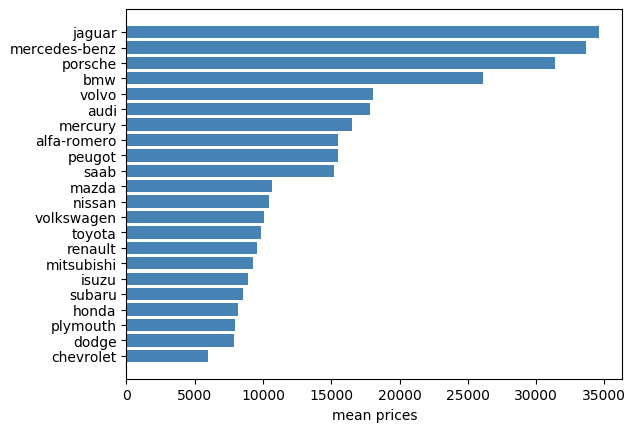

In [4]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(list(np.arange(len(make_p_desc['price']))), list(make_p_desc['price']), color='steelblue')
ax.set_yticks(list(np.arange(len(make_p_desc['price']))))
ax.set_yticklabels(list(make_p_desc.index))
ax.set_xlabel('mean prices')
ax.invert_yaxis()

### Spotting Correlations

Our idea in this section is to select variables for training the model based on having a look at correlations. **Note that price will be our ultimate dependent variable**.

1. Our first objective is to look at a **heatmap** of correlations to spot easily and clearly, the explanatory variables that show a high correlation with **price**. Our initial assumption is that if we include variables that exhibit strong correlations, then the model would be a more accurate predictor of price classes.

2. Our second objective is to spot **multicollinearity** - that is strong correlations between explanatory variables. If two explanatory variables are very strongly correlated, it only makes sense to keep one of them in the model, and not both. 

3. Our third objective is to look at a few **scatterplots** that merely consolidate our beliefs about which variables to select and which to not.

&nbsp;

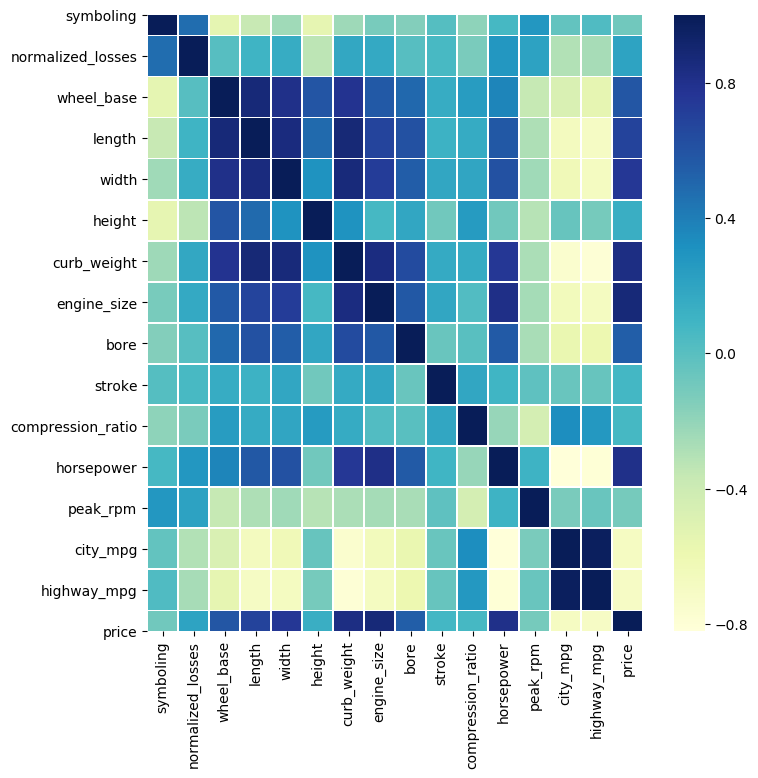

In [122]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), linewidth=0.5, cmap='YlGnBu')

**Selection 1: Length**

,length,price
length,1.000000,0.690628
price,0.690628,1.000000


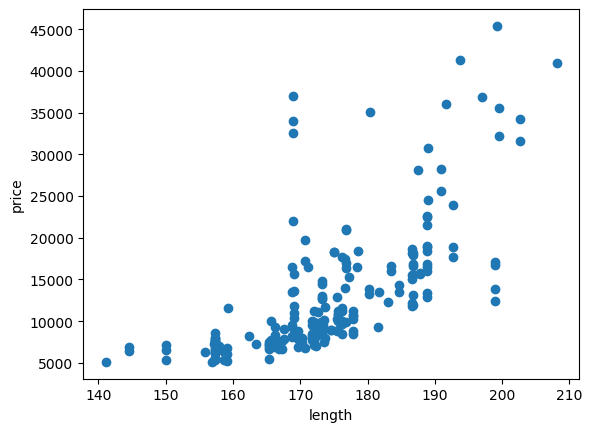

In [123]:
plt.scatter(df['length'], df['price'])
plt.xlabel('length')
plt.ylabel('price')
df[['length', 'price']].corr()   # important variable

**Selection 2: highway_mpg**

,highway_mpg,price
highway_mpg,1.000000,-0.704692
price,-0.704692,1.000000


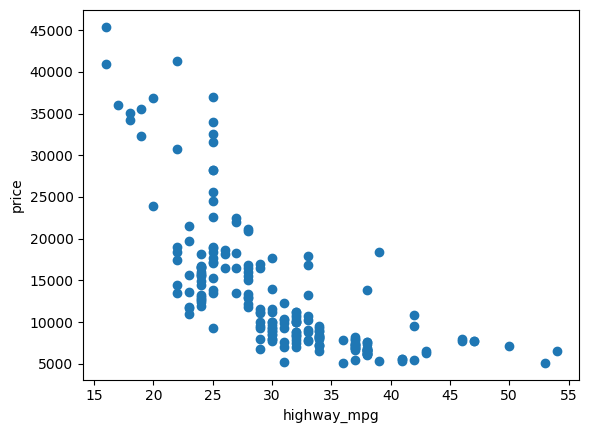

In [124]:
plt.scatter(df['highway_mpg'], df['price'])
plt.xlabel('highway_mpg')
plt.ylabel('price')
df[['highway_mpg', 'price']].corr()   # important variable

,horsepower,price
horsepower,1.000000,0.810795
price,0.810795,1.000000


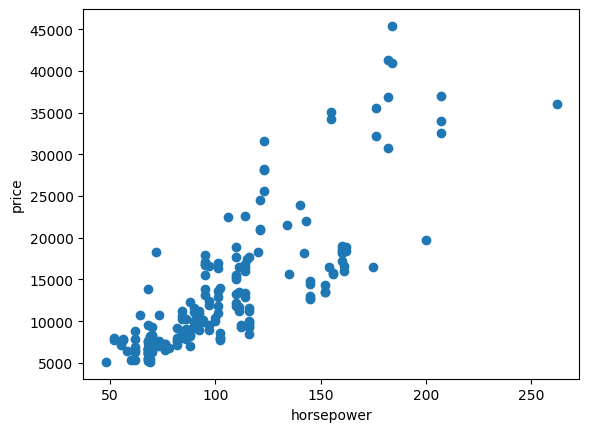

In [125]:
plt.scatter(df['horsepower'], df['price'])
plt.xlabel('horsepower')
plt.ylabel('price')
df[['horsepower', 'price']].corr()   # important variable

&nbsp;

As we go on like this, our final set of **continuous explanatory variables** are:

**wheel_base, length, engine_size, horsepower, highway_mpg**

&nbsp;

### Dummy transformation and Quantile binning

Now we will do a **dummy variable** transformation on a variable that we feel is most consumer specific - **body_style**. In addition we look at segmenting **price** categories using a technique called **quantile binning** wherein the price segments are divided as follows:

1. **Low_budget**: Between $\$5,100$ - $\$7,700$

2. **Economy**: Between $\$7,700$ - $\$10,300$

3. **Premium**: Between $\$10,300$ - $\$16,500$

4. **Luxury**: Between $\$16,500$ - $\$45,500$

&nbsp;

In [9]:
bin_labels = ['low_budget', 'economy', 'premium', 'luxury']
df['quantiles'] = pd.qcut(df['price'], q=4, labels=bin_labels)
df['quantiles'].value_counts()

low_budget    51
luxury        50
premium       50
economy       50
Name: quantiles, dtype: int64

&nbsp;

The point of the above set of class proportions is that it essentially gives us our **Null Model**. This Null Model, as we can see, would correctly predict class labels on average about $25\%$ of the time. The idea is to form models that do much better than this. Keep this in figure in mind as we will refer to this point later on.

&nbsp;

In [10]:
dummy = pd.get_dummies(df[['body_style']])

&nbsp;

After dummy coding the **body_style** variable in the above code block, we get a dataframe of $0$ and $1$ values corresponding to the various body styles. We then essentially merge this **categorical dummy variable dataframe** with our original dataframe by using the **concatenate functionality**. 

After this, we assign **numerical encodings** to our **price bracket class names**. We do this because algorithms understand numerical format of target data. 

&nbsp;

In [11]:
data = pd.concat([df, dummy], axis=1)

In [12]:
bin_label_2 = {'low_budget':1, 'economy':2, 'premium':3, 'luxury':4}
data['classes'] = [bin_label_2[key] for key in data['quantiles']]

&nbsp;

Now we basically **drop** the unnecessary variables for the purpose of model training.

&nbsp;

In [13]:
data_f = data.drop(columns=['symboling', 'normalized_losses', 'make',
                                   'fuel_type', 'aspiration', 'number_of_doors',
                                   'body_style', 'drive_wheels', 'engine_location',
                                   'width', 'height', 'curb_weight',
                                   'engine_type', 'number_of_cylinders',
                                   'fuel_system', 'bore', 'stroke', 'city_mpg',
                                   'price', 'quantiles', 'compression_ratio', 'peak_rpm'])

### Standardizing the dataset

We essentially want to standardize our feature values to basically bring all the features to an equal level of importance. For example - **highway_mpg** values are typically around $20$ and $40$, whereas **engine_size** values are typically between $130$ and $200$. In this scenario we do not want our model mistaking high numbers for higher associated importance of that variable. Rather we would like all the values to have importance in a **relative way**. Hence we basically bring them in a **normalized** form. ***NOTE that we only standardize the continuous variables and not the categorical dummy variables***.

$$Z = \dfrac{X-\mu}{\sigma}$$

In [14]:
data_f.iloc[:, :5] = (data_f.iloc[:, :5] - data_f.iloc[:, :5].mean())/data_f.iloc[:, :5].std()

In [15]:
data_f.head(5)

,wheel_base,length,engine_size,horsepower,highway_mpg,body_style_convertible,body_style_hardtop,body_style_hatchback,body_style_sedan,body_style_wagon,classes
0,-1.680910,-0.438315,0.075201,0.206912,-0.540937,1,0,0,0,0,3
1,-1.680910,-0.438315,0.075201,0.206912,-0.540937,1,0,0,0,0,3
2,-0.708334,-0.243544,0.604724,1.356972,-0.687669,0,0,1,0,0,3
3,0.165335,0.194690,-0.430252,-0.033798,-0.100741,0,0,0,1,0,3
4,0.099398,0.194690,0.219617,0.313895,-1.274597,0,0,0,1,0,4


### Dividing the data into train and test sets

Before the actual division of data into **train** and **test** sets, we will first separate out the **explanatory variable matrix** and the **target vector**. After which we utilize **sklearn** functionality to split the dataset into train and test sets.

&nbsp;

In [16]:
X = data_f.drop('classes', axis=1)
Y = data_f['classes']

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, train_size=0.75)

&nbsp;

# Supervised Model Design

We will not attempt to fit various models on our training data and test it out in predicting class labels on the test data. Consequently we will judge model accuracy using cross validation methods. The idea is to build models by specifying various **hyperparameter** and **modeling tuning** values. However there is a caveat here - while building standalone models, it usually requires some level of trial and error to arrive at a set of **hyperparameters** that give us a certain desired level of model accuracy. 

*With this in mind, we start off with an underlying aim - to get the best model that gives us the best level of prediction accuracy. To achieve this, we begin fitting standalone models with randomly specified hyperparameter values. At each model iteration, we check its level of accuracy to ascertain if that particular model would work well for our application. After demonstrating the use case of each standalone model, we will then use the **GridSearch** functionality to simultaneously test various combinations of hyperparameter specifications, all in an attempt to find the best model. We will finally settle with the one giving us the best accuracy score.*

### Gaussian Naive Bayes Classifier

&nbsp;

In [18]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, Y_train)
y_model = model.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_model)

0.49019607843137253

&nbsp;

We feel that one measure of a model accuracy score might not be sufficient to judge the overall accuracy of the model, so we adopt a **cross validation** approach as well to judge the effectiveness of our model. Throughout the exercise we will be using a $5$ fold cross validation approach.

&nbsp;

In [56]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(model, X, Y, cv=5))

[0.43902439 0.6        0.5        0.45       0.625     ]


In [59]:
print(cross_val_score(model, X, Y, cv=5).mean())

0.5228048780487805


&nbsp;

### Linear SVM

We see that on average this **GaussianBayes** model is decent since on average, it does much better than the **Null Model** with an average test score accuracy of $52\%$, but we can do better than this. Next we will attempt to fit a **linear Support vector classifier** on the data. 

&nbsp;

In [30]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=10)
clf.fit(X_train, Y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [31]:
ymod = clf.predict(X_test)

In [32]:
print(cross_val_score(clf, X, Y, cv=5))

[0.63414634 0.7        0.6        0.625      0.6       ]


In [33]:
print(cross_val_score(clf, X, Y, cv=5).mean())

0.6318292682926829


&nbsp;

### Radial Basis Function SVM

Clearly, on average, this **Linear SVC** model is giving us better measures of model accuracy than the Gaussian Bayes, with an average model accuracy of $63\%$. Now we will see how the **radial basis function SVM** performs. The idea here is to basically apply a function that projects our data onto a higher dimensional space and then attempts to fit a linear hyperplane on this high dimensional data. 

&nbsp;

In [34]:
clf2 = SVC(kernel='rbf', C=10, gamma='auto')
clf2.fit(X_train, Y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
print(cross_val_score(clf2, X, Y, cv=5))

[0.53658537 0.75       0.625      0.575      0.55      ]


In [36]:
print(cross_val_score(clf2, X, Y, cv=5).mean())

0.6073170731707316


&nbsp;

We see that the **Linear SVC** model tends to be better than the one with the **RBF** kernel, under the hyperparameters we have initially specified. Now that most of the standalone models have been specified, we now turn to the **GridSearch** method of finding a good model. We have specified lists of hyperparameters, which are iteratively evaluated and consequently the best model among those combinations of values is obtained. 

&nbsp;

In [50]:
from sklearn.model_selection import GridSearchCV

grid_svm = {'kernel': ['linear', 'poly', 'rbf'],
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': ['auto']}
grid_model = GridSearchCV(estimator=SVC(), param_grid=grid_svm, cv=5, iid=False)
grid_model.fit(X, Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': ['auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [61]:
grid_model.best_params_

{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}

In [67]:
best_svm = grid_model.best_estimator_
print(best_svm.score(X_train, Y_train))
print(round(best_svm.score(X_test, Y_test), 2))

0.74
0.73


&nbsp;

It looks like with method we have found a **significant improvement** over the standalone models. The best model appears to be a **Linear Kernel SVC with a C of 0.1** (Note: a smaller $C$ value implies a larger margin on the SVC hyperplane). 

Not only is this model giving us a good accuracy score of around $74\%$, but it is giving us consistent levels of accuracy over different datasets (train and test sets) - which further implies a healthy **bias** and **variance** tradeoff. 

&nbsp;

### Multinomial Logit

Previously we have established the **Linear SVC** found by **GridSearch** as the best model so far. However for the sake of demonstration we would like to see the behaviour of another important standalone model. Next we will fit a **Multinomial Logistic Regression**. 

&nbsp;

In [53]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logit.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
print(cross_val_score(logit, X, Y, cv=5))

[0.68292683 0.75       0.55       0.625      0.55      ]


In [55]:
print(cross_val_score(logit, X, Y, cv=5).mean())

0.6315853658536585


&nbsp;

### Decision Tree models

Even the **logit** does pretty decently, but as of now, the **linear SVM** stands out as our best model so far as it gives us an accuracy close to $74\%$. Now we would like to check a standalone decision tree along with one found through the **GridSearch** method.

&nbsp;

In [68]:
from sklearn.tree import tree
DT1 = tree.DecisionTreeClassifier(criterion='gini',
                                  random_state=1,
                                  max_depth=4,
                                  min_samples_leaf=20,
                                  min_samples_split=70)

In [69]:
DT1.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=70,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [70]:
DT1.score(X_test, Y_test)

0.6274509803921569

&nbsp;

Again, this model does a fairly decent job, but we could perhaps have a far more optimized tree by using **GridSearch**. Here is the process for that.

&nbsp;

In [73]:
grid_dt = {'criterion': ['gini', 'entropy'],
           'max_depth': [3, 4, 5],
           'min_samples_leaf': [15, 20, 30, 40],
           'min_samples_split': [60, 70, 80, 100],
           'max_features': [3, 4, 5, 6, 8, 10]}

grid_dt_model = GridSearchCV(estimator=tree.DecisionTreeClassifier(), 
                             param_grid=grid_dt, cv=5, iid=False)
grid_dt_model.fit(X, Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid=False, n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5],
                         'max

In [74]:
grid_dt_model.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 4,
 'min_samples_leaf': 20,
 'min_samples_split': 80}

In [78]:
print(grid_dt_model.best_estimator_.score(X_train, Y_train))
print(grid_dt_model.best_estimator_.score(X_test, Y_test))

0.6066666666666667
0.7450980392156863


&nbsp;

Now with this **GridSearch** tree we find ourselves in a bit of a tricky situation. It might just be possible that the Decision Tree is overfitting the data, as a result of which it tends to have a high Variance. This is evident since the model accuracy is not quite as consistent across the train and test sets of the data. 

### Random Forest Models

Let us now try to improve upon that Decision Tree from the previous section. First of all we note that the **Random Forest** is an **ensemble** method that essentially combines the results of many Decision Tree model fits on different subsets of the Data, in an attempt to get us better model accuracy scores. As usual, first we will fit a standalone Random Forest model and subsequently, through a Grid Search.

&nbsp;

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
RF1 = RandomForestClassifier(criterion='gini',
                             random_state=1,
                             n_estimators=400,
                             oob_score=True)
RF1.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

In [82]:
RF1.score(X_test, Y_test)

0.7450980392156863

&nbsp;

This model gives us decent results, now let us turn to the **GridSearch** and see what happens.

&nbsp;

In [90]:
grid_rf = {'criterion': ['gini'],
           'n_estimators': [400, 500],
           'max_features': [5, 10],
           'min_samples_leaf': [30, 40],
           'max_depth': [3, 4]}

grid_rf_model = GridSearchCV(estimator=RandomForestClassifier(random_state=1),
                             param_grid=grid_rf, cv=5, iid=False)

In [91]:
grid_rf_model.fit(X, Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
             iid=False, n_jobs=None,
             param_grid={'cr

In [92]:
grid_rf_model.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 5,
 'min_samples_leaf': 30,
 'n_estimators': 400}

In [95]:
print(grid_rf_model.best_estimator_.score(X_train, Y_train))
print(grid_rf_model.best_estimator_.score(X_test, Y_test))

0.6466666666666666
0.7647058823529411


&nbsp;

Now we see that this **RandomForest** ensemble model with **GridSearch** is certainly better than the previous Decision Tree model. However, it still appears to have some amount of variance while fitting between train and test sets.

Until now, the best model we have so far is the **Linear SVC** found using **GridSearch**. It is giving us consistently high accuracy scores over train and test datasets. So we will finally settle with this model and use it to predict a classification based on **user input**. 

***We do this primarily to demonstrate a practical use case scenario of our model in the hypothetical business environment that we have laid out at the outset.*** 

98, 150, 145, 200, 28,

&nbsp;

In [99]:
wb = int(input("enter a value for wheel base (value between 87 and 121): "))
le = int(input("enter a value for length (value between 142 and 209): "))
eng = int(input("enter a value for engine size (value between 61 and 326): "))
horse = int(input("enter a value for horsepower (value between 48 and 262): "))
high = int(input("enter a value for highway mileage (value between 16 and 54): "))
con = int(input("do you want a convertible? (NO: 0, YES: 1): "))
hardtop = int(input("do you want a hardtop? (NO: 0, YES: 1): "))
hatch = int(input("do you want a hatch? (NO: 0, YES: 1): "))
sedan = int(input("do you want a sedan? (NO: 0, YES: 1): "))
wagon = int(input("do you want a wagon? (NO: 0, YES: 1): "))

enter a value for wheel base (value between 87 and 121):  98
enter a value for length (value between 142 and 209):  150
enter a value for engine size (value between 61 and 326):  145
enter a value for horsepower (value between 48 and 262):  200
enter a value for highway mileage (value between 16 and 54):  28
do you want a convertible? (NO: 0, YES: 1):  0
do you want a hardtop? (NO: 0, YES: 1):  0
do you want a hatch? (NO: 0, YES: 1):  0
do you want a sedan? (NO: 0, YES: 1):  1
do you want a wagon? (NO: 0, YES: 1):  0


In [100]:
vals = pd.DataFrame()
vals['values'] = list([wb, le, eng, horse, high, con, hardtop, hatch, sedan, wagon])

In [101]:
WB = (wb-data['wheel_base'].mean())/data['wheel_base'].std()
LE = (le-data['length'].mean())/data['length'].std()
ENG = (eng-data['engine_size'].mean())/data['engine_size'].std()
HORSE = (horse-data['horsepower'].mean())/data['horsepower'].std()
HIGH = (high-data['highway_mpg'].mean())/data['highway_mpg'].std()

In [102]:
vals['stdvalues'] = list([WB, LE, ENG, HORSE, HIGH, con, hardtop, hatch, sedan, wagon])

In [103]:
if list(best_svm.predict([list(vals['stdvalues'])]))[0] == 1:
    print("You should go for a low budget car - Chevy, Dogde, Plymouth")
elif list(best_svm.predict([list(vals['stdvalues'])]))[0] == 2:
    print("You should go for an economy car - Toyota, Subaru")
elif list(best_svm.predict([list(vals['stdvalues'])]))[0] == 3:
    print("You should go for a premium car - Nissan, BMW")
elif list(best_svm.predict([list(vals['stdvalues'])]))[0] == 4:
    print("=======")
    print("You should go for a luxury car - Mercedes-Benz, Jaguar, Porshe or Volvo")
    print("=======")

You should go for a luxury car - Mercedes-Benz, Jaguar, Porshe or Volvo


&nbsp;

We can see that in this specific case, the user entered corresponding car specifications and preferences, based on which our model has given out a **price segment**, namely - **luxury** and some car recommendations, namely - **Mercedes-Benz, Jaguar, Porshe, Volvo** - which, if you refer to our initial plot, are cars associated with the highest price bracket. 

***We have hence, attemped to solve the business problem of this car rental company by providing them with a user focussed, recommendation model.***


&nbsp;

### A final measure

As a final measure, we compute the **confusion matrix** with diagonal elements representing the correctly predicted class labels by our best model.

&nbsp;

(4.0, 0.0)

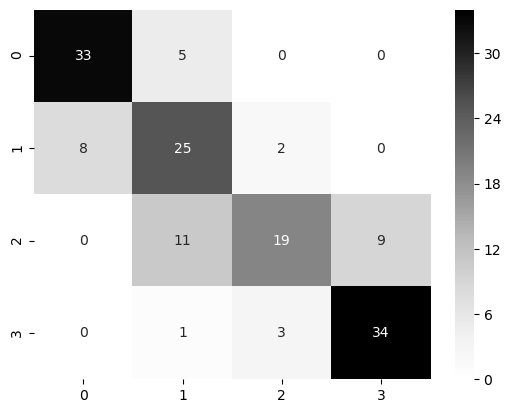

In [121]:
y_train_predict = best_svm.predict(X_train)
ax = sns.heatmap(metrics.confusion_matrix(Y_train, y_train_predict), annot=True, 
                 fmt='.5g', cmap='Greys')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

&nbsp;

# Unsupervised Model Design

We also have a look at a few **unsupervised** learning methods, specifically the **KMeans** algorithms and dimensionality reduction methods like **Principal Component Analysis**. This would allow us to capture similarities in the data, which inturn would allow us to make certain inferences. 

### PCA

Now before we delve into fitting a **PCA** algorithm, our dataset must be free of any **string** or **categorical** data types. So we first exclude them and then standardize our dataset.

&nbsp;

In [83]:
DF = df.select_dtypes(exclude=['object', 'category'])
DF3=(DF-DF.mean())/DF.std()
DF3.head(5)

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,1.720753,1.275161,-1.680910,-0.438315,-0.851335,-2.029015,-0.014821,0.075201,0.523178,-1.830095,-0.290709,0.206912,-0.253100,-0.650624,-0.540937,0.036224
1,1.720753,1.275161,-1.680910,-0.438315,-0.851335,-2.029015,-0.014821,0.075201,0.523178,-1.830095,-0.290709,0.206912,-0.253100,-0.650624,-0.540937,0.414350
2,0.126876,1.275161,-0.708334,-0.243544,-0.185134,-0.558319,0.516789,0.604724,-2.422760,0.655159,-0.290709,1.356972,-0.253100,-0.961995,-0.687669,0.414350
3,0.923814,1.156018,0.165335,0.194690,0.147966,0.217881,-0.422710,-0.430252,-0.520952,0.434947,-0.041019,-0.033798,0.789381,-0.183569,-0.100741,0.093477
4,0.923814,1.156018,0.099398,0.194690,0.243137,0.217881,0.518722,0.219617,-0.520952,0.434947,-0.540399,0.313895,0.789381,-1.117680,-1.274597,0.533891


In [84]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(DF3.T.values)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [85]:
print(pca.explained_variance_ratio_)

[0.42938605 0.20977064]


&nbsp;

From the above **PCA** fit, we see that the **top two** principal components actually explain, cumulatively, around $70\%$ of the data. Since a significant amount of overall variability in the data is **preserved** with these principal components, we will use them as the effective dataset for further computations. Another benefit of this is that it is possible to form convenient **2-D** plots and visualize the data. 

&nbsp;

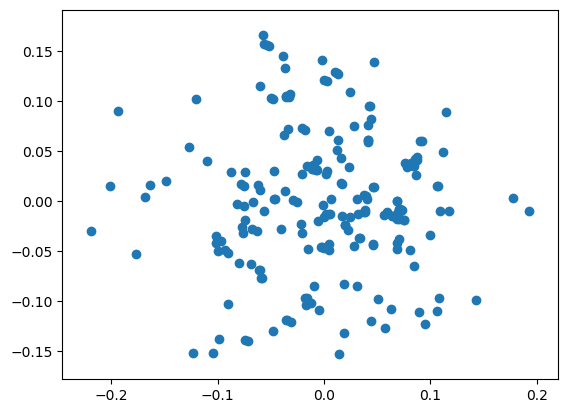

In [86]:
plt.scatter(pca.components_[0], pca.components_[1])

&nbsp;


### KMeans

Now we can notice by simply eyeballing the **PCA plot** that there seems to be broadly three loose clusters in the data. We will take that as a point that informs our **KMeans** specification of clusters. We will specify $3$ clusters and then we how the observations get clustered.

&nbsp;

In [87]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
km.fit(DF3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [88]:
y_kmeans = km.predict(DF3)

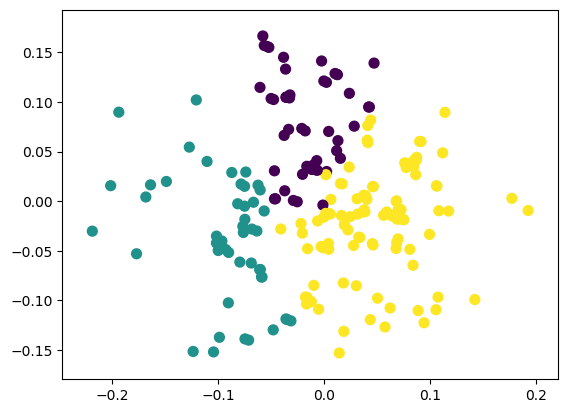

In [89]:
plt.scatter(pca.components_[0], pca.components_[1], c=y_kmeans, s=50, cmap='viridis')

&nbsp;

Based on the above shown cluster allocations, we will now see what are the actual observations that get grouped into the associated clusters.

&nbsp;

In [90]:
clustermap = pd.DataFrame()
clustermap['data_index_values'] = DF3.index.values
clustermap['cluster'] = km.labels_

In [99]:
df.iloc[clustermap[clustermap.cluster == 0].index.values][['price', 'quantiles']].head(10)

,price,quantiles
0,13495,premium
1,16500,premium
2,16500,premium
3,13950,premium
4,17450,luxury
5,15250,premium
9,16430,premium
10,16925,luxury
11,20970,luxury
12,21105,luxury


In [94]:
df.iloc[clustermap[clustermap.cluster == 1].index.values][['price', 'quantiles']].head(10)

,price,quantiles
6,17710,luxury
7,18920,luxury
8,23875,luxury
13,24565,luxury
14,30760,luxury
15,41315,luxury
16,36880,luxury
44,32250,luxury
45,35550,luxury
46,36000,luxury


In [95]:
df.iloc[clustermap[clustermap.cluster == 2].index.values][['price', 'quantiles']].head(10)

,price,quantiles
17,5151,low_budget
18,6295,low_budget
19,6575,low_budget
20,5572,low_budget
21,6377,low_budget
22,7957,economy
23,6229,low_budget
24,6692,low_budget
25,7609,low_budget
26,8558,economy


&nbsp;

Upon initial glances at the data, we can see that **KMeans** has clubbed the **low budget and some economy** cars together. **one segment belongs almost entirely by the luxury segment**. Then there is a cluster largely with **premium cars**.

This **unsupervised** analysis would give us further insight into what could perhaps be more accurate definitions of the **price segment** class labels. 

We could even use this initial clustering to form even more complex data models that can attempt to make car model recommendations. 

&nbsp;

# Conclusion

By now, we have looked at the data from various aspects - **through exploratory plots, supervised learing models, unsupervised learning models**. Using all these models and various complimentary processes, we were able to achieve the following:

1. Prepare a usable model that can make recommendations to users depending on their inputs.

2. Obtain further insights from dimensional reduction and unsupervised analysis.

We ultimately feel that the rental car company might greatly benefit from such Data Analysis processes, since better recommendations and classifications would not only lead to a higher customer satisfaction with the website, but will also allow the company to profile its customers and essentially do a **customer segmentation**, based on which targeted advertisements could be provided as well.